In [2]:
from tkinter import *
from tkinter import ttk
from scipy import cluster
from scipy import spatial
from sklearn import metrics 
from sklearn import preprocessing
from warnings import simplefilter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, single, complete, average, leaves_list
from scipy.spatial.distance import squareform, pdist
from yellowbrick.cluster import silhouette_visualizer
import xml.etree.ElementTree as et
import tkinter.filedialog
from collections import defaultdict
from sklearn.metrics import silhouette_score
import math


import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
simplefilter("ignore", cluster.hierarchy.ClusterWarning)
encoder = preprocessing.LabelEncoder()
scalar = preprocessing.MinMaxScaler()

In [4]:
def select_knowledge_base():
    etree = et.parse(tkinter.filedialog.askopenfilename())
    return etree.getroot()

In [5]:
def select_knowledge_base_rules(knowledge_base):
    rule_attr_list = [xml.attrib for xml in knowledge_base.iter('rule')]
    rule_attr_dict = rule_attr_list.copy()
    rule_attr_data_frame = pd.DataFrame(list(rule_attr_dict))
    return rule_attr_data_frame

In [6]:
def select_knowledge_base_attributes(knowledge_base):
    attribute_attr_list = [a.attrib for a in knowledge_base.find('attributes').iter('name')]
    attribute_attr_dict = attribute_attr_list.copy()
    attributes_attr_data_frame = pd.DataFrame(list(attribute_attr_dict))
    attributes_attr_data_frame.drop('valueID', axis='columns', inplace=True)
    attributes_attr_data_frame.dropna(subset=['attributeID'], inplace=True)
    return attributes_attr_data_frame

In [7]:
def init_rule_matrix(rule_data_frame, attribute_data_frame):
    for x in attribute_data_frame.values:
        rule_data_frame['attr_' + x] = np.nan
    return rule_data_frame

In [8]:
def get_rule_by_id(xml_root, id_rule):
    for rule in xml_root.iter('rule'):
        if rule.attrib['ruleID'] == id_rule:
            return rule

In [9]:
def populate_matrix_with_conditions(knowledge_base, data_frame):
    for i in range(len(list(data_frame.ruleID))):
        for k in list(get_rule_by_id(knowledge_base, data_frame.ruleID[i]).find('conditions')):
            data_frame.loc[
                data_frame['ruleID'] == data_frame.ruleID[i], str(
                    'attr_' + list(k)[0].attrib['attributeID'])] = list(k)[2].text
    return data_frame

In [10]:
def populate_matrix_with_conclusions(knowledge_base, data_frame):
    for i in range(len(list(data_frame.ruleID))):
        for k in list(get_rule_by_id(knowledge_base, data_frame.ruleID[i]).find('conclusion')):
            data_frame.loc[
                data_frame['ruleID'] == data_frame.ruleID[i], str(
                    'attr_' + list(k)[0].attrib['attributeID'])] = list(k)[2].text
    return data_frame

In [11]:
def get_simbolic_values(knowledge_base):
    symbolic_value = []
    t = [a for a in knowledge_base.find('attributes').iter('symbolic_value')]
    for x in range(len(list(t))):
        symbolic_value.append(list(t)[x].find('name').text)
    return set(symbolic_value)

In [12]:
def normilize_types_of_column_values(data_frame, column):
    try:
        data_frame[column] = pd.to_numeric(data_frame[column], downcast="float")
    except:
        data_frame[column] = data_frame[column].astype(str)
    

In [13]:
def compiute_result(data, distance_type, linkage_type):
    plt.figure(figsize=(20, 7))
    diff = 0
    grouped = []
    dist = pd.DataFrame(squareform(spatial.distance.pdist(data, distance_type)), columns=data.index.values, index=data.index.values)
    if linkage_type=='complete':
        start = time.time()
        grouped = complete(dist)
        end = time.time()
        diff = end - start
    if linkage_type=='average':
        start = time.time()
        grouped = average(dist)
        end = time.time()
        diff = end - start
    if linkage_type=='ward':
        start = time.time()
        grouped = ward(dist)
        end = time.time()
        diff = end - start
    if linkage_type=='single':
        start = time.time()
        grouped = single(dist)
        end = time.time()
        diff = end - start
    dendro = cluster.hierarchy.dendrogram(grouped, labels=data.index)
    cluster_labels = cluster.hierarchy.fcluster(grouped,len(get_cluster_classes(dendro)), 'maxclust', R=None, monocrit=None)
    plt.title(f'Hierarchical Clustering Dendrogram - {distance_type} distance, {linkage_type} linkage')
    plt.show()
    return diff, dendro, cluster_labels, dist

In [14]:
def isNan(x):
    return x!=x

In [15]:
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

In [16]:
"""Read Knowledge base"""
knowledge_base = select_knowledge_base()

In [17]:
"""Read Knowledge base rules"""
knowledge_base_rules = select_knowledge_base_rules(knowledge_base)

In [18]:
knowledge_base_rules

,number,ruleID
0,1,11655
1,2,11656
2,3,11657
3,4,11658
4,5,11659
5,6,11660
6,7,11661
7,8,11662
8,9,11663
9,10,11664


In [19]:
"""Read knowledge base attributes"""
knowledge_base_attributes = select_knowledge_base_attributes(knowledge_base)

In [20]:
knowledge_base_attributes

,attributeID
0,1220
3,1221
6,1222
8,1223
11,1224
13,1225
16,1226
18,1227
20,1228
22,1229


In [21]:
"""Initialize data frame"""
init_data = init_rule_matrix(knowledge_base_rules, knowledge_base_attributes)

In [22]:
init_data

,number,ruleID,attr_1220,attr_1221,attr_1222,attr_1223,attr_1224,attr_1225,attr_1226,attr_1227,attr_1228,attr_1229,attr_1230,attr_1231
0,1,11655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,11658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,11659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,11660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,11661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,11662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,11663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,11664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
"""populate data frame with conditions"""
populate_matrix_with_conditions(knowledge_base, init_data)

,number,ruleID,attr_1220,attr_1221,attr_1222,attr_1223,attr_1224,attr_1225,attr_1226,attr_1227,attr_1228,attr_1229,attr_1230,attr_1231
0,1,11655,a1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11656,a1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11657,NaN,NaN,NaN,NaN,d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,11658,NaN,b2,NaN,NaN,d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,11659,NaN,b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,11660,NaN,NaN,NaN,c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,11661,NaN,NaN,NaN,NaN,NaN,e1,NaN,NaN,NaN,NaN,NaN,NaN
7,8,11662,NaN,NaN,NaN,NaN,NaN,NaN,f1,NaN,NaN,NaN,NaN,NaN
8,9,11663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,g1,NaN,NaN,NaN,NaN
9,10,11664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i1,NaN,NaN


In [24]:
"""populate data frame with conditions"""
populate_matrix_with_conclusions(knowledge_base, init_data)

,number,ruleID,attr_1220,attr_1221,attr_1222,attr_1223,attr_1224,attr_1225,attr_1226,attr_1227,attr_1228,attr_1229,attr_1230,attr_1231
0,1,11655,a1,b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11656,a1,NaN,NaN,c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11657,NaN,NaN,NaN,NaN,d1,e1,NaN,NaN,NaN,NaN,NaN,NaN
3,4,11658,NaN,b2,NaN,NaN,d1,NaN,f1,NaN,NaN,NaN,NaN,NaN
4,5,11659,NaN,b1,NaN,NaN,NaN,NaN,NaN,g1,NaN,NaN,NaN,NaN
5,6,11660,NaN,NaN,NaN,c1,NaN,NaN,NaN,g1,NaN,NaN,NaN,NaN
6,7,11661,NaN,NaN,NaN,NaN,NaN,e1,NaN,NaN,h1,NaN,NaN,NaN
7,8,11662,NaN,NaN,NaN,NaN,NaN,NaN,f1,NaN,h1,NaN,NaN,NaN
8,9,11663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,g1,NaN,i1,NaN,NaN
9,10,11664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i1,k1,NaN


In [25]:
"""Set index to data"""
indexed_data = init_data.set_index('ruleID')

In [26]:
indexed_data

,number,attr_1220,attr_1221,attr_1222,attr_1223,attr_1224,attr_1225,attr_1226,attr_1227,attr_1228,attr_1229,attr_1230,attr_1231
ruleID,,,,,,,,,,,,,
11655,1,a1,b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11656,2,a1,NaN,NaN,c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11657,3,NaN,NaN,NaN,NaN,d1,e1,NaN,NaN,NaN,NaN,NaN,NaN
11658,4,NaN,b2,NaN,NaN,d1,NaN,f1,NaN,NaN,NaN,NaN,NaN
11659,5,NaN,b1,NaN,NaN,NaN,NaN,NaN,g1,NaN,NaN,NaN,NaN
11660,6,NaN,NaN,NaN,c1,NaN,NaN,NaN,g1,NaN,NaN,NaN,NaN
11661,7,NaN,NaN,NaN,NaN,NaN,e1,NaN,NaN,h1,NaN,NaN,NaN
11662,8,NaN,NaN,NaN,NaN,NaN,NaN,f1,NaN,h1,NaN,NaN,NaN
11663,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,g1,NaN,i1,NaN,NaN


In [27]:
"""Remove number column from data frame"""
if 'number' in indexed_data:
    indexed_data.drop('number', axis = 1, inplace = True)

In [28]:
indexed_data

,attr_1220,attr_1221,attr_1222,attr_1223,attr_1224,attr_1225,attr_1226,attr_1227,attr_1228,attr_1229,attr_1230,attr_1231
ruleID,,,,,,,,,,,,
11655,a1,b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11656,a1,NaN,NaN,c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11657,NaN,NaN,NaN,NaN,d1,e1,NaN,NaN,NaN,NaN,NaN,NaN
11658,NaN,b2,NaN,NaN,d1,NaN,f1,NaN,NaN,NaN,NaN,NaN
11659,NaN,b1,NaN,NaN,NaN,NaN,NaN,g1,NaN,NaN,NaN,NaN
11660,NaN,NaN,NaN,c1,NaN,NaN,NaN,g1,NaN,NaN,NaN,NaN
11661,NaN,NaN,NaN,NaN,NaN,e1,NaN,NaN,h1,NaN,NaN,NaN
11662,NaN,NaN,NaN,NaN,NaN,NaN,f1,NaN,h1,NaN,NaN,NaN
11663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,g1,NaN,i1,NaN,NaN


In [29]:
indexed_data.fillna('*')

,attr_1220,attr_1221,attr_1222,attr_1223,attr_1224,attr_1225,attr_1226,attr_1227,attr_1228,attr_1229,attr_1230,attr_1231
ruleID,,,,,,,,,,,,
11655,a1,b1,*,*,*,*,*,*,*,*,*,*
11656,a1,*,*,c1,*,*,*,*,*,*,*,*
11657,*,*,*,*,d1,e1,*,*,*,*,*,*
11658,*,b2,*,*,d1,*,f1,*,*,*,*,*
11659,*,b1,*,*,*,*,*,g1,*,*,*,*
11660,*,*,*,c1,*,*,*,g1,*,*,*,*
11661,*,*,*,*,*,e1,*,*,h1,*,*,*
11662,*,*,*,*,*,*,f1,*,h1,*,*,*
11663,*,*,*,*,*,*,*,g1,*,i1,*,*


In [32]:
for column in indexed_data.columns:
    column_values = indexed_data[column][isNan(indexed_data[column])==False].values
    print(column_values)
    print(sorted(set(column_values)))
    for i in sorted(set(column_values)):
        indexed_data.loc[indexed_data[column] == i, column] = sorted(set(column_values)).index(i)+1

[1 1 1 1 1 1]
[1]
[1 2 1 1 1 1 1]
[1, 2]
[1 1 1 1 1 1]
[1]
[1 1 2 2 2]
[1, 2]
[1 1]
[1]
[1 1 2 2]
[1, 2]
[1 1]
[1]
[1 1 1]
[1]
[1 1 1]
[1]
[1 1 1]
[1]
[1 1]
[1]
[1]
[1]


In [31]:
indexed_data

,attr_1220,attr_1221,attr_1222,attr_1223,attr_1224,attr_1225,attr_1226,attr_1227,attr_1228,attr_1229,attr_1230,attr_1231
ruleID,,,,,,,,,,,,
11655,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11656,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11657,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN
11658,NaN,2,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN
11659,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
11660,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
11661,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN
11662,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN
11663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN


In [30]:
indexed_data = indexed_data.fillna(0)
indexed_data.to_csv('b.csv')

In [31]:
indexed_data = indexed_data.apply(pd.to_numeric)

In [32]:
indexed_data.to_csv('c.csv')

In [33]:
indexed_data

,attr_1220,attr_1221,attr_1222,attr_1223,attr_1224,attr_1225,attr_1226,attr_1227,attr_1228,attr_1229,attr_1230,attr_1231
ruleID,,,,,,,,,,,,
11655,1,1,0,0,0,0,0,0,0,0,0,0
11656,1,0,0,1,0,0,0,0,0,0,0,0
11657,0,0,0,0,1,1,0,0,0,0,0,0
11658,0,2,0,0,1,0,1,0,0,0,0,0
11659,0,1,0,0,0,0,0,1,0,0,0,0
11660,0,0,0,1,0,0,0,1,0,0,0,0
11661,0,0,0,0,0,1,0,0,1,0,0,0
11662,0,0,0,0,0,0,1,0,1,0,0,0
11663,0,0,0,0,0,0,0,1,0,1,0,0


In [34]:
result_columns = {'knowledge_base','Rule_count', 'Atribute_count','Cluster_count', 'Distance_messure','Linkage_method', 'Largest_group_count','Smalest_group_count', 'Computation_time' , 'silhouette_score'}
result = pd.DataFrame(columns=result_columns)        


    1.Euclidean
    2.Canberra
    3.Manhattan
    4.Chebyshev
    5.Exit/Quit
    


Choose distance measure: 1


***********************************
******Distance type euclidean******
***********************************

    1.Single
    2.Complete
    3.Average
    4.Ward
    5.Exit/Quit
    


Choose linkage type?  4


******************************
*****linkage type ward******
******************************
******************************
***Computations starting...***
******************************


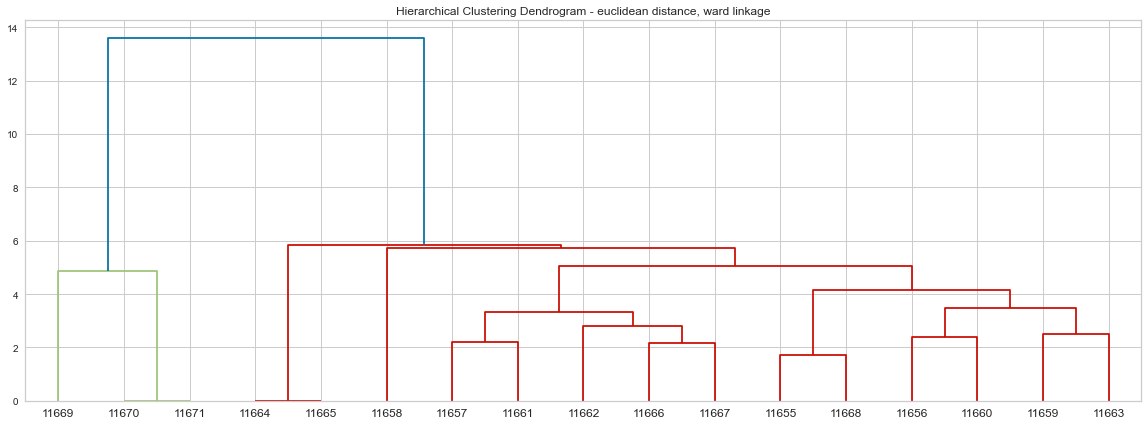

In [39]:
distance_loop = True
linkage_loop = True
distance_type = ''
linkage_type = ''
distance_ans = ''
linkage_ans = ''
while distance_loop:
    print("""
    1.Euclidean
    2.Canberra
    3.Manhattan
    4.Chebyshev
    5.Exit/Quit
    """)
    distance_ans = input("Choose distance measure:")
    if distance_ans == "1":
        print('***********************************')
        distance_type = 'euclidean'
        print('******Distance type euclidean******')
        print('***********************************')
        break
    elif distance_ans == "2":
        print('**********************************')
        distance_type = 'canberra'
        print('******Distance type canberra******')
        print('**********************************')
        break
    elif distance_ans == "3":
        print('***********************************')
        distance_type = 'cityblock'
        print('******Distance type cityblock******')
        print('***********************************')
        break
    elif distance_ans == "4":
        print('***********************************')
        distance_type = 'chebyshev'
        print('******Distance type chebyshev******')
        print('***********************************')
        break
    elif distance_ans == "5":
        print('***********************************')
        print('******Tank You!!!******')
        print('***********************************')
        break
    elif distance_ans != "":
        print("\n Not Valid Choice Try again")

while linkage_loop:
    print("""
    1.Single
    2.Complete
    3.Average
    4.Ward
    5.Exit/Quit
    """)
    linkage_ans = input("Choose linkage type? ")
    if linkage_ans == "1":
        print('******************************')
        print('*****linkage type single******')
        print('******************************')
        print('******************************')
        print('***Computations starting...***')
        print('******************************')
        diff, dendro, cluster_labels, dist = compiute_result(indexed_data, distance_type=distance_type,
                                                         linkage_type='single')
        print(len(dendro['color_list']))
        silhouette_score = metrics.silhouette_score(dist, cluster_labels,  metric='precomputed')

        try:
            print(silhouette_score)
            result = result.append(
                {'knowledge_base': knowledge_base.attrib.get('kbName'), 'Rule_count': len(indexed_data.index.values),
                 'Atribute_count': len(indexed_data.columns.values), 'Cluster_count': len(get_cluster_classes(dendro)),
                 'Distance_messure': distance_type, 'Linkage_method': 'single',
                 'Largest_group_count': len(max(get_cluster_classes(dendro).values(), key=len)),
                 'Smalest_group_count': len(min(get_cluster_classes(dendro).values(), key=len)),
                 'Computation_time': diff, 'silhouette_score': silhouette_score}, ignore_index=True)
        except:
            result = result.append(
                {'knowledge_base': knowledge_base.attrib.get('kbName'), 'Rule_count': len(indexed_data.index.values),
                 'Atribute_count': len(indexed_data.columns.values), 'Cluster_count': len(get_cluster_classes(dendro)),
                 'Distance_messure': distance_type, 'Linkage_method': 'single',
                 'Largest_group_count': len(max(get_cluster_classes(dendro).values(), key=len)),
                 'Smalest_group_count': len(min(get_cluster_classes(dendro).values(), key=len)),
                 'Computation_time': diff, 'silhouette_score': None}, ignore_index=True)
        break
    elif linkage_ans == "2":
        print('******************************')
        linkage_type = 'complete'
        print('*****linkage type complete******')
        print('******************************')
        print('******************************')
        print('***Computations starting...***')
        print('******************************')
        diff, dendro, cluster_labels, dist = compiute_result(indexed_data, distance_type=distance_type,
                                                             linkage_type='complete')
        print(dendro['color_list'])
        try:
            silhouette_score = metrics.silhouette_score(dist,cluster_labels,  metric='precomputed')
            result = result.append(
                {'knowledge_base': knowledge_base.attrib.get('kbName'), 'Rule_count': len(indexed_data.index.values),
                 'Atribute_count': len(indexed_data.columns.values), 'Cluster_count': len(get_cluster_classes(dendro)),
                 'Distance_messure': distance_type, 'Linkage_method': 'complete',
                 'Largest_group_count': len(max(get_cluster_classes(dendro).values(), key=len)),
                 'Smalest_group_count': len(min(get_cluster_classes(dendro).values(), key=len)),
                 'Computation_time': diff, 'silhouette_score': silhouette_score}, ignore_index=True)
        except:
            result = result.append(
                {'knowledge_base': knowledge_base.attrib.get('kbName'), 'Rule_count': len(indexed_data.index.values),
                 'Atribute_count': len(indexed_data.columns.values), 'Cluster_count': len(get_cluster_classes(dendro)),
                 'Distance_messure': distance_type, 'Linkage_method': 'complete',
                 'Largest_group_count': len(max(get_cluster_classes(dendro).values(), key=len)),
                 'Smalest_group_count': len(min(get_cluster_classes(dendro).values(), key=len)),
                 'Computation_time': diff, 'silhouette_score': None}, ignore_index=True)
        break
    elif linkage_ans == "3":
        print('******************************')
        print('*****linkage type average******')
        print('******************************')
        print('******************************')
        print('***Computations starting...***')
        print('******************************')
        diff, dendro, cluster_labels, dist = compiute_result(indexed_data, distance_type=distance_type,
                                                             linkage_type='average')
        try:
            silhouette_score = metrics.silhouette_score(dist, cluster_labels,  metric='precomputed')
            result = result.append(
                {'knowledge_base': knowledge_base.attrib.get('kbName'), 'Rule_count': len(indexed_data.index.values),
                 'Atribute_count': len(indexed_data.columns.values), 'Cluster_count': len(get_cluster_classes(dendro)),
                 'Distance_messure': distance_type, 'Linkage_method': 'average',
                 'Largest_group_count': len(max(get_cluster_classes(dendro).values(), key=len)),
                 'Smalest_group_count': len(min(get_cluster_classes(dendro).values(), key=len)),
                 'Computation_time': diff, 'silhouette_score': silhouette_score}, ignore_index=True)
        except:
            result = result.append(
                {'knowledge_base': knowledge_base.attrib.get('kbName'), 'Rule_count': len(indexed_data.index.values),
                 'Atribute_count': len(indexed_data.columns.values), 'Cluster_count': len(get_cluster_classes(dendro)),
                 'Distance_messure': distance_type, 'Linkage_method': 'average',
                 'Largest_group_count': len(max(get_cluster_classes(dendro).values(), key=len)),
                 'Smalest_group_count': len(min(get_cluster_classes(dendro).values(), key=len)),
                 'Computation_time': diff, 'silhouette_score': None}, ignore_index=True)
        break
    elif linkage_ans == "4":
        print('******************************')
        linkage_type = 'ward'
        print('*****linkage type ward******')
        print('******************************')
        print('******************************')
        print('***Computations starting...***')
        print('******************************')
        diff, dendro, cluster_labels, dist = compiute_result(indexed_data, distance_type=distance_type,
                                                             linkage_type='ward')
        try:
            silhouette_score = metrics.silhouette_score(dist, cluster_labels,  metric='precomputed')
            result = result.append(
                {'knowledge_base': knowledge_base.attrib.get('kbName'), 'Rule_count': len(indexed_data.index.values),
                 'Atribute_count': len(indexed_data.columns.values), 'Cluster_count': len(get_cluster_classes(dendro)),
                 'Distance_messure': distance_type, 'Linkage_method': 'ward',
                 'Largest_group_count': len(max(get_cluster_classes(dendro).values(), key=len)),
                 'Smalest_group_count': len(min(get_cluster_classes(dendro).values(), key=len)),
                 'Computation_time': diff, 'silhouette_score': silhouette_score}, ignore_index=True)
        except:
            result = result.append(
                {'knowledge_base': knowledge_base.attrib.get('kbName'), 'Rule_count': len(indexed_data.index.values),
                 'Atribute_count': len(indexed_data.columns.values), 'Cluster_count': len(get_cluster_classes(dendro)),
                 'Distance_messure': distance_type, 'Linkage_method': 'ward',
                 'Largest_group_count': len(max(get_cluster_classes(dendro).values(), key=len)),
                 'Smalest_group_count': len(min(get_cluster_classes(dendro).values(), key=len)),
                 'Computation_time': diff, 'silhouette_score': None}, ignore_index=True)
        break
    elif linkage_ans == "5":
        print('***********************************')
        print('******Tank You!!!******')
        print('***********************************')
        break
    elif linkage_ans != "":
        print("\n Not Valid Choice Try again")

In [40]:
result

,Atribute_count,Rule_count,Distance_messure,Largest_group_count,Smalest_group_count,knowledge_base,silhouette_score,Linkage_method,Computation_time,Cluster_count
0,12,17,euclidean,8,2,test_2B_mod_09_09_2015_09_00_51,0.275434,single,0.001000,4
1,12,17,euclidean,14,3,test_2B_mod_09_09_2015_09_00_51,0.379945,complete,0.000000,2
2,12,17,euclidean,14,1,test_2B_mod_09_09_2015_09_00_51,0.289772,average,0.001001,3
3,12,17,euclidean,15,3,test_2B_mod_09_09_2015_09_00_51,0.379945,ward,0.000000,2


In [ ]:
result = result.set_index('knowledge_base')

In [ ]:
result

In [ ]:
file_name = knowledge_base.attrib.get('kbName');
result.to_csv(f'tests/{file_name}.csv', mode='a', header=True)